In [3]:
from utils import *
from collision import *
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects
from matplotlib.path import Path
from scipy.ndimage import gaussian_filter

%load_ext autoreload
%autoreload 2

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
class motor_environment(Simulation):
    #this is our interaction! The environment changes temperature and motion of the particle
    def update_velocity(self, p, x_ind, y_ind):
        if len(self.srf["field"].shape) > 2:
            vx = .02*self.srf["field"][0, x_ind, y_ind]
            vy = .02*self.srf["field"][1, x_ind, y_ind]
            
            p.vx, p.vy = p.vx + vx, p.vy + vy
            
        elif len(self.srf["field"].shape) == 2:
            if self.srf.field[x_ind, y_ind] > 0:
                p.v = 1.01*p.v #+ .15self.srf.field[x_ind, y_ind]*self.dt
            if self.srf.field[x_ind, y_ind] < 0:
                p.v = .95*p.v #+ .01*self.srf.field[x_ind, y_ind]*self.dt    
        else:
            pass

    def handle_collisions(self):
        """Detect and handle any collisions between the Particles.

        When two Particles collide, they do so elastically: their velocities
        change such that both energy and momentum are conserved.

        """ 

        # We're going to need a sequence of all of the pairs of particles when
        # we are detecting collisions. combinations generates pairs of indexes
        # into the self.particles list of Particles on the fly.
        pairs = combinations(range(self.n), 2)
        
        for i,j in pairs:
            if self.particles[i].overlaps(self.particles[j]):
                self.change_velocities(self.particles[i], self.particles[j])
           
        
    def update_temperature(self, p, x_ind, y_ind):
        if hasattr(p, 'temperature'): 

            if len(sim.srf.field.shape) > 2:
                p.temperature = p.temperature + (np.hypot(*self.srf.field[:, x_ind, y_ind]) - 2.0) 

            elif len(self.srf["field"].shape) == 2:

                    p.temperature = p.temperature + self.srf.field[x_ind, y_ind]*(self.dt) 

    def update_particle_sensors(self, p, x_ind, y_ind, particle_grid):
        if hasattr(p, 'temperature_state'): 
            if len(self.srf["field"].shape) == 2:
                if hasattr(p, 'sensors'):
                     
                    p.temperature_state[((p.sensors[:, 0] + 2)/2).astype(int), 
                                        ((p.sensors[:, 1] + 2)/2).astype(int)] = self.srf.field[x_ind +
                                                                                                p.sensors[:, 0],
                                                                                                y_ind + 
                                                                                                p.sensors[:, 1]]
        if hasattr(p, 'food_state'):
            if len(self.srf["field"].shape) == 2:
                if hasattr(p, 'sensors'):
                    p.food_state[((p.sensors[:, 0] + 2)/2).astype(int), 
                                        ((p.sensors[:, 1] + 2)/2).astype(int)] = particle_grid[x_ind + 
                                                                                               3*p.sensors[:, 0], 
                                                                                               y_ind + 
                                                                                               3*p.sensors[:, 1]]
    def setup_animation(self):
        
        self.fig = plt.figure(figsize = [7, 8]) # axes = plt.subplots(3,2, subplot_kw = {'adjustable' : 'datalim'},
                  #                     gridspec_kw={'height_ratios': [1, 2, 5]}, figsize = [8, 10])
        
        
        self.top_ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=1)
        self.top_ax2 = plt.subplot2grid((5, 3), (1, 0), colspan=1)
        self.ri_ax = plt.subplot2grid((5, 3), (0, 1), colspan=2, rowspan = 2)
        
        self.ax = plt.subplot2grid((5, 3), (2, 0), colspan = 3, rowspan = 3)
       

        self.srf.plot(fig = self.fig, ax = self.ax)

        
        self.ax.set_title("")
        self.ax.xaxis.set_ticks([])
        self.ax.yaxis.set_ticks([])
        

        self.ri_ax.xaxis.set_ticks([])
        self.ri_ax.yaxis.set_ticks([])
        

        
        sns.despine(ax = self.ri_ax)
        sns.despine(ax = self.top_ax1, bottom = True, left = True)
        sns.despine(ax = self.top_ax2, bottom = True, left = True)
        sns.despine(ax = self.ax)                                                                                          

        plt.tight_layout()
    def interact(self, p, particle_grid):
            #bounce the particle off the walls
        self.handle_boundary_collisions(p)

        #change the temperature of the agent
        x_ind, y_ind = self.get_grid_inds(p)

        self.update_particle_sensors(p, x_ind, y_ind, particle_grid)

        self.update_velocity(p, x_ind, y_ind)
        #move faster in high temp regions

        self.update_temperature(p, x_ind, y_ind)

                
           # p.v = .95*p.v
        
    def animate(self, i):
        """The function passed to Matplotlib's FuncAnimation routine."""
        self.ri_ax.cla() # clear the previous image
    
        self.ri_ax.plot(np.array(self.particles[0].temp_log) ,  c = 'r', label = 'temperature')# plot the line
        self.ri_ax.plot(np.array(self.particles[0].food_log) ,  c = 'k', label = 'food store')
        self.ri_ax.legend()
        
        sns.despine(ax = self.ri_ax)
        
        self.top_ax1.cla()
        self.top_ax1.imshow(self.particles[0].temperature_state.transpose(1, 0), origin = "lower")
        
        self.top_ax1.set_title("temperature sensor state")
                               
        sns.despine(ax = self.top_ax1, bottom = True, left = True)
        
        
        self.top_ax2.cla()
        self.top_ax2.imshow(self.particles[0].food_state.transpose(1, 0), cmap = 'pink', vmin = 0, vmax = .1, origin = "lower")
        
        self.top_ax2.set_title("food sensor state")
        
        sns.despine(ax = self.top_ax2, bottom = True, left = True)
        
        self.top_ax1.xaxis.set_ticks([])
        self.top_ax1.yaxis.set_ticks([])
        self.top_ax2.xaxis.set_ticks([])
        self.top_ax2.yaxis.set_ticks([])
        
        self.advance_animation()
        
        return self.circles
                
    def advance(self):
        """Advance the animation by dt."""
        particle_grid = np.zeros_like(self.srf.field)
        particle_xy_list = np.array([self.get_grid_inds(p) for p in self.particles])
        particle_grid[particle_xy_list[:, 0], particle_xy_list[:, 1]] = 1.0
        self.particle_grid = gaussian_filter(particle_grid, sigma = 2)
        
        for i, p in enumerate(self.particles):
            if p.delete:
                self.particles.remove(p)
                self.n -=1
            else:
                p.advance(self.dt)
                self.interact(p, self.particle_grid)
        
        self.handle_collisions()
        
    def advance_animation(self):
        """Advance the animation by dt, returning the updated Circles list."""
        particle_grid = np.zeros_like(self.srf.field)
        particle_xy_list = np.array([self.get_grid_inds(p) for p in self.particles[1:]])
        particle_grid[particle_xy_list[:, 0], particle_xy_list[:, 1]] = 5.0
        self.particle_grid = gaussian_filter(particle_grid, sigma = 5)       
        
        
        for i, p in enumerate(self.particles):
           #clean up the eaten food 
            self.handle_collisions()
            
            if p.delete:
                self.particles.remove(p)
                self.n -=1
                self.circles[i].radius = 0
                self.circles.pop(i)
                
            else:   
                p.advance(self.dt)
                self.interact(p, self.particle_grid)
                #self.handle_boundary_collisions(p)
                try:
                    self.circles[i].set_xy = p.r
                except:
                    pass
                
                
        
        
        sim.circles[0].remove()
        sim.circles[0] = self.particles[0].draw(self.ax)    
        
        
        
        return self.circles


In [5]:
class motor_agent(Particle):
    """A class representing a two-dimensional particle."""
    def __init__(self, x = .5, y = .5, vx = 0, vy=0, radius = .05, styles = 
                 {'edgecolor': 'k', 'linewidth': 2, 'alpha': 1, 'facecolor': 'k'} , 
                 food_store = 100, n_sensors = 3):
        
        self.r = np.array((x, y)).astype('float32')
        self.v = np.array((vx, vy)).astype('float32')
        
        self.temperature_state = np.zeros([n_sensors, n_sensors])
        self.food_state = np.zeros([n_sensors, n_sensors])
        pairs = product(range(n_sensors), range(n_sensors))
        self.sensors = (np.array([[i, j] for i, j in pairs]) - 1)*2
        
        self.hidden_radius = radius
        self.radius = 2.5*radius
        self.mass = self.radius**2
        self.delete = False
        self.styles = styles
        if not self.styles:
            # Default circle styles
            self.styles = {'edgecolor': 'c', 'fill': False}
        self.food_store = food_store
        self.temperature = 98; 
        self.set_point = 98 #homeostatic temp
        self.margin =  .5
        self.last_temp = 98
        self.last_vel = np.array((vx, vy)).astype('float32')
        
        self.eat = False
        self.temp_log = []
        self.food_log = []
        self.grad_log = []
    
    def homeostasis_monitor(self):
        return self.temperature - self.set_point
    
    def temp_change_monitor(self):
        return self.temperature - self.last_temp
    def overlaps(self, other):
        """Does the circle of this Particle overlap that of other?"""
        overlap = np.hypot(*(self.r - other.r)) < (self.radius + other.radius)
        
        if self.eat and overlap:
            other.delete = True
            other.radius = 0
            self.food_store += 1
            self.eat = False
            
        return overlap
  
    
    def consume(self):
    
        self.food_store -= .1;

         
    def move(self, dt):
        self.r += self.v * dt
        
    
    def move_colder(self, dt):
        self.consume()
        
        cold_dir = self.sensors[np.argmin(self.temperature_state)]
        self.v = .95*self.v
        self.v += cold_dir*(dt*5)
        
        
    def move_hotter(self, dt):
        self.consume()
        
        hot_dir = self.sensors[np.argmax(self.temperature_state)]
        
        self.v = .95*self.v
        self.v += hot_dir*(dt*5)
        
    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""
        
        #do basic functions
        #check internal state
        dtemp = self.homeostasis_monitor()
        
        if abs(dtemp) > self.margin:
            if dtemp < 0:
                self.move_hotter(dt)
            if dtemp > 0:
                self.move_colder(dt)
                
        if self.food_store < 100:
            self.eat = True
        else:
            self.eat = False
        
        self.move(dt)
        self.exist(dt)
        
    def draw(self, ax):
        """Add this Particle's Circle patch to the Matplotlib Axes ax."""

        circle = Path.circle(center = self.r, radius = self.hidden_radius)#Circle(xy=self.r, radius=self.radius, **self.styles)
    
        patch = patches.PathPatch(circle, facecolor = None, lw=2, path_effects=[
        patheffects.withTickedStroke(angle=-90, spacing=8, length=2)]);
        
        ax.add_patch(patch)
        
        return patch
            
    def exist(self, dt):
        
        self.grad_log.append(np.sign(self.v[0]))
        
        self.temp_log.append(self.temperature)
        self.food_log.append(self.food_store)
        self.last_temp = self.temperature
        self.last_vel = self.v
        #this means we're dead!
        if self.food_store < 0:
            self.delete = True
        if self.temperature < 90 or self.temperature > 105:
            self.delete = True

In [13]:
srf = generate_tempgrad(scale = .08)

sim = motor_environment(n = 10, srf = srf)
p = motor_agent(vx = .1, vy = .1)

sim.particles.insert(0, p)


<IPython.core.display.Javascript object>


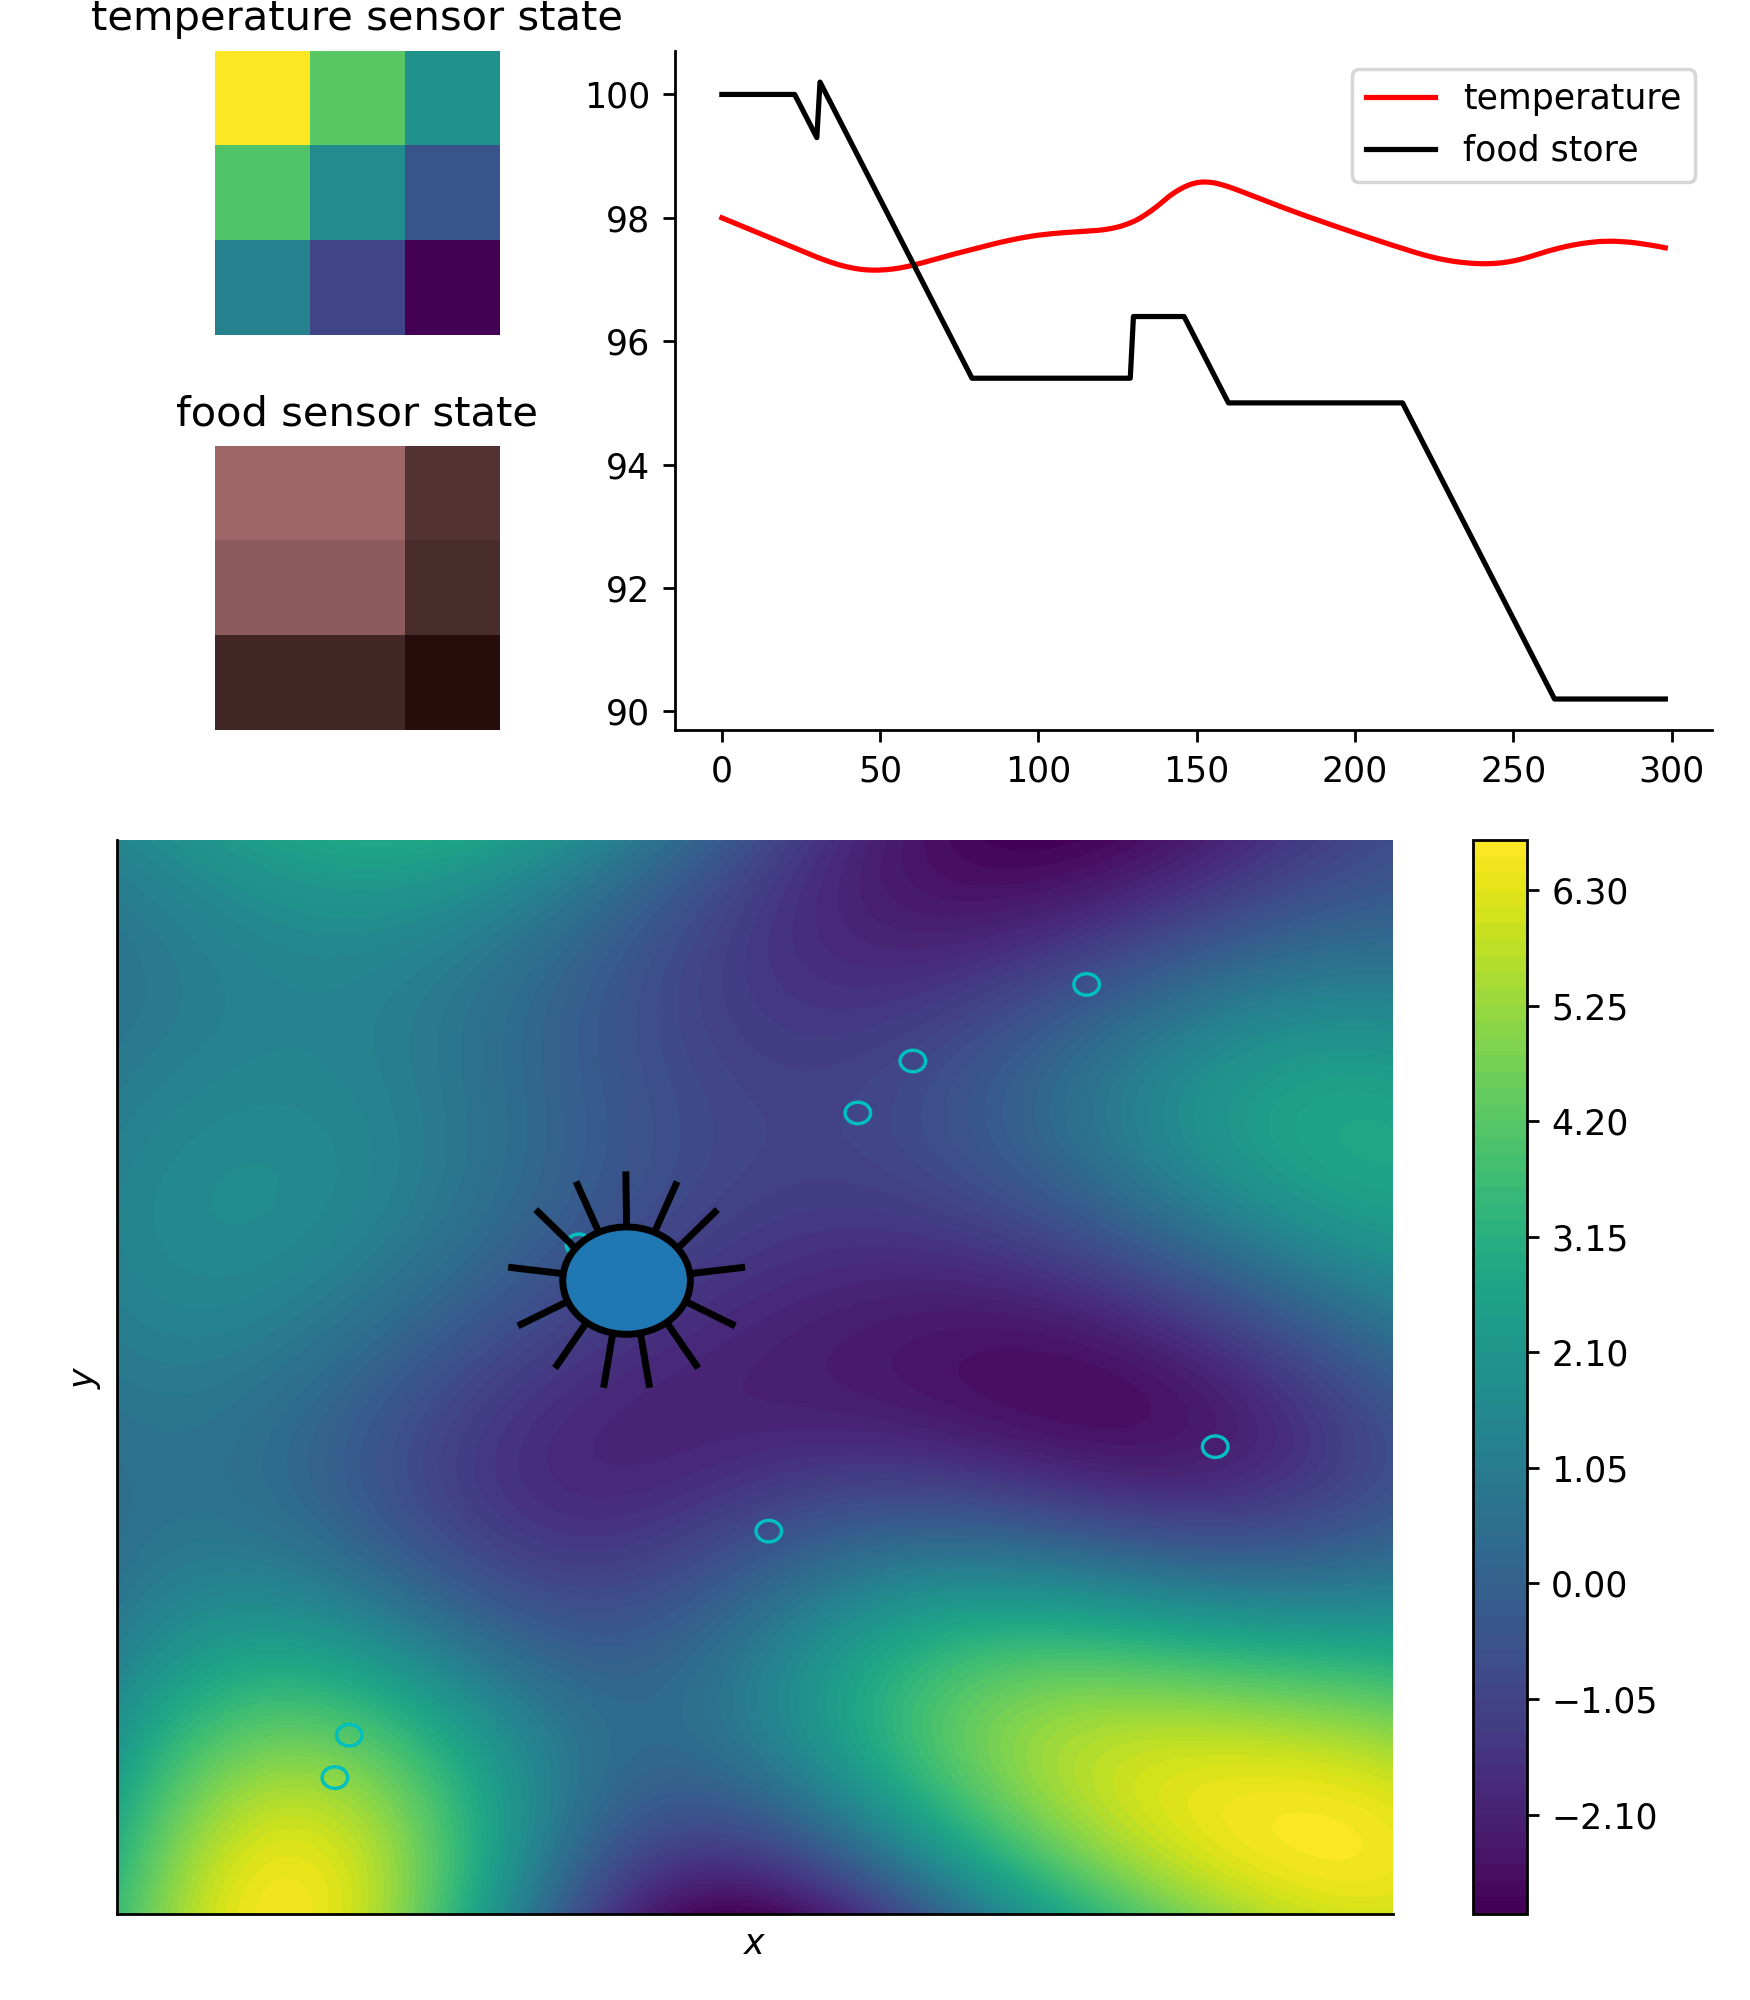

In [14]:
%matplotlib notebook

sim.do_animation(save=False)